In [131]:
# Common imports
import numpy as np
import os
import sys


# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Vanishing/Exploding Gradients Problem

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

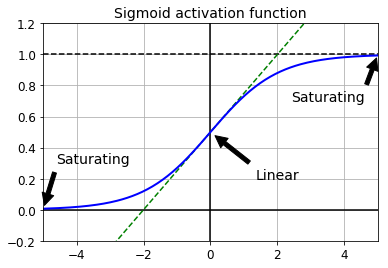

In [13]:
z = np.linspace(-5, 5, 200)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [1, 1], 'k--')
plt.plot([0, 0], [-0.2, 1.2], 'k-')
plt.plot([-5, 5], [-3/4, 7/4], 'g--')

plt.plot(z, logit(z), 'b-', linewidth=2)

props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha='center')
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha='center')

plt.grid(True)
plt.title('Sigmoid activation function', fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

純粋にシグモイド関数を活性化関数として使うと，誤差伝搬処理において勾配が消失したり爆発したりする．

# Xavier and He Initialization

学習する重みパラメータの初期値を工夫することで，勾配消失や爆発を対処しようというアプローチ  
肝心なのは，順伝搬と逆伝搬で流れる信号を適切に流すこと．信号が無くなったり飽和するのは困る．  
信号を正しく流すためには各層の出力と入力の分散を等しくする必要がある．実際には各層の入力と出力の接続数を等しくする必要がある．  
（ただし接続数を変えたいので）妥協案として，入力と出力の接続数を使った初期化方法を考えた．

Xavierの初期値（ロジスティック関数の場合）：  
$平均=0$  
$標準偏差 = \sqrt{\frac{2}{n_inputs + n_outputs}}$

**Note**: It is now preferable to use tf.layers.dense() rather than tensorflow.contrib.layers.fully_connected(), because anything in the contrib module may change or be deleted without notice!!  
The dense() function is almost identical to the fully_connected() function. 

In [21]:
import tensorflow as tf

**tf.layer.dense()では，デフォルトでXavierの初期値を使っている．**

In [19]:
reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')

In [20]:
he_init = tf.variance_scaling_initializer
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, kernel_initializer=he_init, name='hidden1')

# Nonsaturating Activation Functions

活性化関数の選び方を工夫すれば，勾配消失や爆発を緩和できるのではないかというアプローチ．  
母なる自然が生物学的ニューロンでシグモイド関数を使うことを選んだのだから素晴らしい選択であるに違いないとほとんどの人々が思っていたが，深層ニューラルネットワークでは他の活性化関数の方が優れた挙動を示すことがわかった．  
特に正の値で飽和しない（かつ素早く計算ができる）ReLU関数である．  
しかし，ReLUは訓練中に一部のニューロンがずっと０を出力し続ける**dying ReLU**と呼ばれる問題を引き起こす．ReLUは入力が負ならば０なので，そのニューロンが生き返る見込みは完全に無い．  
この問題を解決するためにReLUの変種がいくつか存在する．

## Leaky ReLU

z < 0 でも僅かに誤差をリークさせる（漏らす）  
これにより，負値の場合に長い昏睡状態に入ることはあるが，生き返る可能性は残されている．  
通常のReLUよりも常に高い性能を発揮することが報告されている．しかも$\alpha = 0.2$（大きなリーク）の方が$\alpha = 0.01$よりも性能が高くなるようだ．

In [14]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

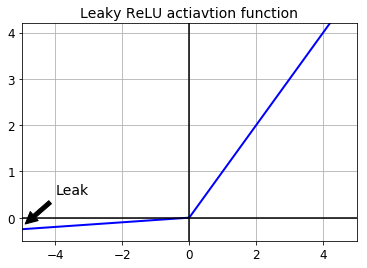

In [16]:
z = np.linspace(-5, 5, 200)

plt.plot(z, leaky_relu(z, 0.05), 'b-', linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')

plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha='center')
plt.title('Leaky ReLU actiavtion function', fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

Implementing Leaky ReLU in TensorFlow:

In [35]:
reset_graph()

In [36]:
def leaky_relu(z, name=None):
    return tf.maximum(0.01*z, z, name=name)

Let's train a neural network on MNIST using the Leaky ReLU.  
First let's a create the graph:

In [37]:
reset_graph()

n_inputs = 28 * 28 # MNIST
n_hidden1 = 300
n_hidden2 = 200
n_output = 10

In [38]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')

In [39]:
with tf.name_scope('dnn'):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=leaky_relu, name='hidden1')
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=leaky_relu, name='hidden2')
    logits = tf.layers.dense(hidden2, n_output, name='outputs')

In [40]:
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

In [41]:
learning_rate = 0.01

with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

In [42]:
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

In [43]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

Let's load the data:

In [44]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)
X_valid, X_train = X_train[:5000], X_train[5000:]
y_valid, y_train = y_train[:5000], y_train[5000:]

In [45]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [46]:
n_epochs = 40
batch_size = 50

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if epoch % 5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
            print(epoch, 'Batch accuracy:', acc_batch, 'Validation accuracy:', acc_valid)
    
    save_path = saver.save(sess, './model/Leaky_ReLU_final.ckpt')

0 Batch accuracy: 0.88 Validation accuracy: 0.9022
5 Batch accuracy: 0.94 Validation accuracy: 0.9484
10 Batch accuracy: 0.94 Validation accuracy: 0.9656
15 Batch accuracy: 0.94 Validation accuracy: 0.9702
20 Batch accuracy: 1.0 Validation accuracy: 0.9732
25 Batch accuracy: 0.98 Validation accuracy: 0.9752
30 Batch accuracy: 1.0 Validation accuracy: 0.9758
35 Batch accuracy: 1.0 Validation accuracy: 0.9782


## ELU

Exponetial Linear Unit  
すなわち，負値の部分が指数関数的に変化するというもの（-1に漸近する）

In [99]:
def elu(z, alpha=1):
    return np.where(z<0, alpha * (np.exp(z)-1), z) # -1に漸近させるためにexpから-1をひく

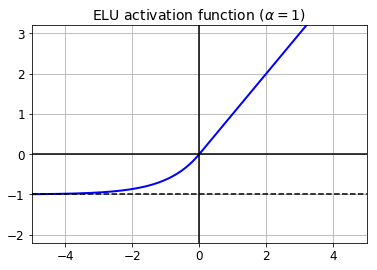

In [49]:
plt.plot(z, elu(z), 'b-', linewidth=2)

plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [50]:
reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')

In [51]:
hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.elu, name='hidden1')

## SELU

-2に漸近させる

In [52]:
from scipy.special import erfc

alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [53]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

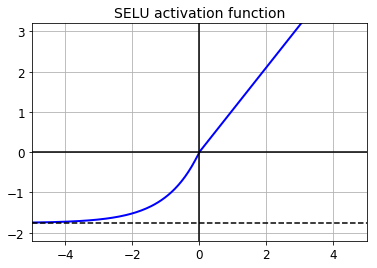

In [54]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [57]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) #standardized inputs

for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer%100 == 0:
        print('Layer {}: mean {:2f}, std deviation {:.2f}'.format(layer, means, stds))

Layer 0: mean -0.001832, std deviation 1.00
Layer 100: mean 0.022381, std deviation 0.96
Layer 200: mean 0.009595, std deviation 0.90
Layer 300: mean -0.015195, std deviation 0.92
Layer 400: mean 0.054134, std deviation 0.89
Layer 500: mean 0.005853, std deviation 0.93
Layer 600: mean 0.022269, std deviation 0.92
Layer 700: mean -0.018259, std deviation 0.90
Layer 800: mean 0.053810, std deviation 0.83
Layer 900: mean 0.019839, std deviation 1.00


The tf.nn.selu() function was added in TensorFlow 1.4. For earlier versions, you can use the following implementation:

In [60]:
def selu(z, scale=alpha_0_1, alpha=scale_0_1):
    return scale * tf.where(z >=0.0, z, alpha * tf.nn.elu(z))

**NOTE:**
However, the SELU activation function cannot be used along with regular Dropout (this would cancel the SELU activation function's self-normalizing property). Fortunately, there is a Dropout variant called Alpha Dropout proposed in the same paper. It is available in  tf.contrib.nn.alpha_dropout() since TF 1.4 (or check out this implementation by the Institute of Bioinformatics, Johannes Kepler University Linz).

Let's create a neural net for MNIST using the SELU activation function:

In [61]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

learning_rate = 0.01

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()
n_epochs = 40
batch_size = 50

Now let's train it, **Do not forget to scale the inputs to mean 0 and standard deviation 1:**

In [62]:
means = X_train.mean(axis=0, keepdims=True)
stds = X_train.std(axis=0, keepdims=True) + 1e-10
X_val_scaled = (X_valid - means) / stds

In [64]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch%5 == 0:
            acc_batch = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            acc_valid = accuracy.eval(feed_dict={X: X_val_scaled, y: y_valid})
            print(epoch, 'Batch accuracy:', acc_batch, 'Validation accuracy:', acc_valid)
            
    save_path = saver.save(sess, './model/SELU_final.ckpt')

0 Batch accuracy: 0.92 Validation accuracy: 0.9338
5 Batch accuracy: 0.98 Validation accuracy: 0.961
10 Batch accuracy: 1.0 Validation accuracy: 0.9682
15 Batch accuracy: 1.0 Validation accuracy: 0.9686
20 Batch accuracy: 1.0 Validation accuracy: 0.9692
25 Batch accuracy: 1.0 Validation accuracy: 0.9696
30 Batch accuracy: 1.0 Validation accuracy: 0.9702
35 Batch accuracy: 1.0 Validation accuracy: 0.9696


## どの活性化関数が良い？？

一般に，ELU > leaky ReLU（およびその変種） >  ReLU > 双曲線正接 > ロジスティック である．  
実行時のスピードが気になる場合は，ELUよりもleaky Reluの方が良い．  
ハイパーパラメータをいじりたく無い場合は，デフォルト$\alpha$（leaky Relu:0.01, ELU:1）で良い．  
時間と計算パワーに余裕があるならば，交差検定を試してみるのも良い．

# Batch Normalization

上記，パラメータ初期値と活性化関数の選択によって，勾配消失/爆発が大幅に改善されるが，この問題が必ず解決される保証はない．  
勾配消失/爆発問題だけでなく，訓練中に前の層のパラメータ変化に伴い各層の入力分布が変化する問題（=内部共変量シフト）に着目し，この問題に対処するために，**バッチ正規化**を考えた．  
**各層の活性化関数を実行する前に，**０を中心とするセンタリングかつ正規化を行う（つまり，層ごとにスケーリング用とシフト用の新たな２つのパラメータをもつ）．言い換えれば，各層の入力の最適なスケールと平均をモデルに学習させる．

全てのDNNで，バッチ正則化によりかなり効果が上がっている．  
勾配消失問題は強力に緩和され，活性化関数として双曲線正接やロジスティック関数のような飽和する関数さえ使えるようになった．  
また，ネットワークが重みの初期値から受ける影響も下がった．  
そして，従来よりも大きな学習率を使えるようになり，訓練プロセスが大幅に高速化した．  
しかも，バッチ正規化は正則項としても機能するため，他の正則化テクニック（ドロップアウトなど）が必要な場面が減る．

しかし，バッチ正則化はモデルを複雑にする．そして，各層で余分な計算が行われるため予測が遅くなる． 
そのため，非常に高速な予測が必要ならばバッチ正規化を試してみる前に，プレーンなELU+He初期化をまずは試したい．

In [78]:
n_inputs = 28 * 28
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

## pattern1

In [104]:
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
training = tf.placeholder_with_default(False, shape=(), name='training')

BNは，移動平均を計算するために，指数関数的平均（exponential decay）を使うために，momentumパラメータが必須となる．  
新しい値（$v$）が与えられると移動平均（$\hat v$）は，  
$\hat v ← \hat v * momentum + v * (1 - momentum)$  
で更新される．

In [105]:
hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1')
#### Batch Normalization
bn1 = tf.layers.batch_normalization(hidden1, training=training, momentum=0.9)
####
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name='hidden2')
####
bn2 = tf.layers.batch_normalization(hidden2, training=training, momentum=0.9)
####
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_output, name='outputs')
logits = tf.layers.batch_normalization(logits_before_bn, training=training, momentum=0.9)

## pattern2

In [80]:
reset_graph()
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
training = tf.placeholder_with_default(False, shape=(), name='training')

To avoid repeating the same parameters over and over again, we can use Python's partial() function:

In [81]:
from functools import partial

my_batch_norm_layer = partial(tf.layers.batch_normalization, training=training, momentum=0.9)

hidden1 = tf.layers.dense(X, n_hidden1, name='hidden1')
bn1 = my_batch_norm_layer(hidden1)
bn1_act = tf.nn.elu(bn1)

hidden2 = tf.layers.dense(bn1_act, n_hidden2, name='hidden2')
bn2 = my_batch_norm_layer(hidden2)
bn2_act = tf.nn.elu(bn2)

logits_before_bn = tf.layers.dense(bn2_act, n_output, name='outputs')
logits = my_batch_norm_layer(logits_before_bn)

## MNIST using the ELU and Batch Normalization

In [109]:
reset_graph()

batch_norm_momentum = 0.9

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name='X')
y = tf.placeholder(tf.int32, shape=(None), name='y')
training = tf.placeholder_with_default(False, shape=(), name='training')

In [110]:
with tf.name_scope('dnn'):
    he_init = tf.variance_scaling_initializer()
    
    my_batch_norm_layer = partial(
        tf.layers.batch_normalization,
        training=training,
        momentum=batch_norm_momentum
    )
    
    my_dense_layer = partial(
        tf.layers.dense,
        kernel_initializer=he_init
    )
    
    hidden1 = my_dense_layer(X, n_hidden1, name='hidden1')
    bn1 = tf.nn.elu(my_batch_norm_layer(hidden1))
    hidden2 = my_dense_layer(bn1, n_hidden2, name='hidden2')
    bn2 = tf.nn.elu(my_batch_norm_layer(hidden2))
    logits_before_bn = my_dense_layer(bn2, n_output, name='outputs')
    logits = my_batch_norm_layer(logits_before_bn)
    
with tf.name_scope('loss'):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name='loss')

learning_rate = 0.01
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)
    
with tf.name_scope('eval'):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))
    
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [111]:
n_epochs = 20
batch_size = 200

**NOTE:**
since we are using tf.layer.batch_normalization(), we need to explicitly run the extra update oprations needed by batch normalization

もう少し噛み砕くと，訓練中に各ステップで移動平均を計算することを含め，いくつかのオペレーションを作成する．これらのオペレーションは自動で，UPDATE_OPSコレクションに追加されるため，各訓練イテレーションでこのコレクション内のオペレーションのリストを得るようにする必要がある．  
そうしないと，バッチ正規化に必要な移動平均，移動分散が学習過程で更新されない．

また，バッチ正規化のtriainigプレースホルダーTrueを入れること．

In [112]:
extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run([training_op, extra_update_ops], feed_dict={training: True, X: X_batch, y:y_batch})
    
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)
        
    save = saver.save(sess, './model/MNIST_ELU_BN.ckpt')

0 Validation accuracy: 0.9096
1 Validation accuracy: 0.9308
2 Validation accuracy: 0.942
3 Validation accuracy: 0.9524
4 Validation accuracy: 0.9566
5 Validation accuracy: 0.9612
6 Validation accuracy: 0.9622
7 Validation accuracy: 0.9648
8 Validation accuracy: 0.965
9 Validation accuracy: 0.9682
10 Validation accuracy: 0.9676
11 Validation accuracy: 0.969
12 Validation accuracy: 0.9698
13 Validation accuracy: 0.9698
14 Validation accuracy: 0.9726
15 Validation accuracy: 0.9726
16 Validation accuracy: 0.9734
17 Validation accuracy: 0.9738
18 Validation accuracy: 0.9752
19 Validation accuracy: 0.9756


もっと深いDNNの時に，より効果が発揮されることに留意しよう．

コレクションに関しては，下記のようにもかける

In [ ]:
with tf.name_scope('train'):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(extra_update_ops):
        training_op = optimizer.minimize(loss)

この場合は，実行フェーズはこう書けば良い

In [ ]:
sess.run(training_op, feed_dict={training: True, X: X_batch, y: y_batch})

**NOTE:** trainable variablesはglobal_variablesの一部であることに注意．例えば移動平均はnon trainable variablesである．  
よって，pretrainedモデルを使いたければ（下の方で出てくる），これらのnon trainable variablesを忘れないようにしないといけない．

In [113]:
[v.name for v in tf.trainable_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0']

In [114]:
[v.name for v in tf.global_variables()]

['hidden1/kernel:0',
 'hidden1/bias:0',
 'batch_normalization/gamma:0',
 'batch_normalization/beta:0',
 'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'hidden2/kernel:0',
 'hidden2/bias:0',
 'batch_normalization_1/gamma:0',
 'batch_normalization_1/beta:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'outputs/kernel:0',
 'outputs/bias:0',
 'batch_normalization_2/gamma:0',
 'batch_normalization_2/beta:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0']

In [118]:
set([v.name for v in tf.global_variables()]) - set([v.name for v in tf.trainable_variables()])

{'batch_normalization/moving_mean:0',
 'batch_normalization/moving_variance:0',
 'batch_normalization_1/moving_mean:0',
 'batch_normalization_1/moving_variance:0',
 'batch_normalization_2/moving_mean:0',
 'batch_normalization_2/moving_variance:0'}

# Gradient Clipping

単純にバックプロパゲーションステップで，勾配をクリッピングし，一定の閾値を超えないようにしようという発想．

TensorFlowのオプティマイザのminimize()関数は，勾配の計算と適用の両方を行うので，  
勾配の計算用関数と，適用関数に分割し，その間にクリッピングオペレーションを追加する．

In [119]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 50
n_hidden3 = 50
n_hidden4 = 50
n_hidden5 = 50
n_outputs = 10

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=tf.nn.relu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=tf.nn.relu, name="hidden2")
    hidden3 = tf.layers.dense(hidden2, n_hidden3, activation=tf.nn.relu, name="hidden3")
    hidden4 = tf.layers.dense(hidden3, n_hidden4, activation=tf.nn.relu, name="hidden4")
    hidden5 = tf.layers.dense(hidden4, n_hidden5, activation=tf.nn.relu, name="hidden5")
    logits = tf.layers.dense(hidden5, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

In [120]:
learning_rate = 0.01

In [121]:
threshold = 1.0

optimizer = tf.train.GradientDescentOptimizer(learning_rate)
grads_and_vars = optimizer.compute_gradients(loss)
###
capped_gvs = [(tf.clip_by_value(grad, -threshold, threshold), var) for grad, var in grads_and_vars]
###
training_op = optimizer.apply_gradients(capped_gvs)

In [122]:
with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name="accuracy")

In [123]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [124]:
n_epochs = 20
batch_size = 200

In [125]:
with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, "Validation accuracy:", accuracy_val)

    save_path = saver.save(sess, "./model/CLIP_model_final.ckpt")

0 Validation accuracy: 0.5088
1 Validation accuracy: 0.8334
2 Validation accuracy: 0.889
3 Validation accuracy: 0.9096
4 Validation accuracy: 0.9196
5 Validation accuracy: 0.9222
6 Validation accuracy: 0.9326
7 Validation accuracy: 0.9388
8 Validation accuracy: 0.94
9 Validation accuracy: 0.9444
10 Validation accuracy: 0.9482
11 Validation accuracy: 0.9486
12 Validation accuracy: 0.9512
13 Validation accuracy: 0.9562
14 Validation accuracy: 0.9548
15 Validation accuracy: 0.9588
16 Validation accuracy: 0.9614
17 Validation accuracy: 0.961
18 Validation accuracy: 0.963
19 Validation accuracy: 0.9628


# Reusing Pretrained Layers

## Reusing a TensorFlow Model

First you need to load the graph's structure.(import_meta_graph() loads the graph's into the default graph, and returns a Saver that you can then use to restore the model's state.)  

In [126]:
reset_graph()

In [127]:
saver = tf.train.import_meta_graph('./model/CLIP_model_final.ckpt.meta')

In [128]:
for op in tf.get_default_graph().get_operations():
    print(op.name)

X
y
hidden1/kernel/Initializer/random_uniform/shape
hidden1/kernel/Initializer/random_uniform/min
hidden1/kernel/Initializer/random_uniform/max
hidden1/kernel/Initializer/random_uniform/RandomUniform
hidden1/kernel/Initializer/random_uniform/sub
hidden1/kernel/Initializer/random_uniform/mul
hidden1/kernel/Initializer/random_uniform
hidden1/kernel
hidden1/kernel/Assign
hidden1/kernel/read
hidden1/bias/Initializer/zeros/shape_as_tensor
hidden1/bias/Initializer/zeros/Const
hidden1/bias/Initializer/zeros
hidden1/bias
hidden1/bias/Assign
hidden1/bias/read
dnn/hidden1/MatMul
dnn/hidden1/BiasAdd
dnn/hidden1/Relu
hidden2/kernel/Initializer/random_uniform/shape
hidden2/kernel/Initializer/random_uniform/min
hidden2/kernel/Initializer/random_uniform/max
hidden2/kernel/Initializer/random_uniform/RandomUniform
hidden2/kernel/Initializer/random_uniform/sub
hidden2/kernel/Initializer/random_uniform/mul
hidden2/kernel/Initializer/random_uniform
hidden2/kernel
hidden2/kernel/Assign
hidden2/kernel/read


Oops, that's a lot of operations!  
It's much easier to use TensorBoard to visualize the graph.

In [143]:
from datetime import datetime
now = datetime.utcnow().strftime('%Y%m%d%H%M%S')
root_logdir = 'tf_logs'
logdir = '{}/run-{}'.format(root_logdir, now)

file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())
file_writer.close()

Once you know which operation you need (**operation node** in TensorBoard), you can get a handle on them using the graph's.

In [149]:
X = tf.get_default_graph().get_tensor_by_name('X:0')
y = tf.get_default_graph().get_tensor_by_name('y:0')

accuracy = tf.get_default_graph().get_tensor_by_name('eval/accuracy:0')

training_op = tf.get_default_graph().get_operation_by_name('GradientDescent')

事前に計算に必要なtensorおよびoperationをコレクションに保存しておくこともできる．

In [146]:
# 書き出し
for op in (X, y, accuracy, training_op):
    tf.add_to_collection('my_important_ops', op)
    
# 読み込み
X, y, accuracy, training_op = tf.get_collection('my_important_ops')

ValueError: too many values to unpack (expected 4)

Now you can start a session, restore the model's state and continue training on your data:

In [152]:
with tf.Session() as sess:
    saver.restore(sess, './model/CLIP_model_final.ckpt')
    
    for epoch in range(n_epochs):
        for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
            sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        accuracy_val = accuracy.eval(feed_dict={X: X_valid, y: y_valid})
        print(epoch, 'Validation accuracy:', accuracy_val)

INFO:tensorflow:Restoring parameters from ./model/CLIP_model_final.ckpt
0 Validation accuracy: 0.9636
1 Validation accuracy: 0.9648
2 Validation accuracy: 0.9644
3 Validation accuracy: 0.9652
4 Validation accuracy: 0.9658
5 Validation accuracy: 0.9634
6 Validation accuracy: 0.9672
7 Validation accuracy: 0.9688
8 Validation accuracy: 0.97
9 Validation accuracy: 0.9698
10 Validation accuracy: 0.9702
11 Validation accuracy: 0.9702
12 Validation accuracy: 0.9714
13 Validation accuracy: 0.9716
14 Validation accuracy: 0.968
15 Validation accuracy: 0.9714
16 Validation accuracy: 0.9686
17 Validation accuracy: 0.9724
18 Validation accuracy: 0.9714
19 Validation accuracy: 0.971
